In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import math
import random
import librosa

In [2]:
DATA_PATH = "/content/drive/MyDrive/Music Data Mining/data_10.json"

In [3]:
with open(DATA_PATH, 'r') as f:
  data = json.load(f)
  X = np.array(data['mfcc'])
  y = np.array(data['labels'])

In [4]:
X.shape

(9986, 130, 13)

In [5]:
y.shape

(9986,)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [7]:
# from sklearn.model_selection import KFold
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [8]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape

(130, 13, 1)

In [10]:
def create_model(f1, k1, u1, d1, lr):
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters = f1, kernel_size = k1, activation = 'relu', padding = 'same', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D(pool_size = 3, padding = 'same'))

  model.add(keras.layers.Conv2D(filters = f1, kernel_size = k1, activation = 'relu', padding = 'same', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D(pool_size = 3, padding = 'same'))

  model.add(keras.layers.Conv2D(filters = f1, kernel_size = k1, activation = 'relu', padding = 'same', input_shape = input_shape))
  model.add(keras.layers.MaxPool2D(pool_size = 2, padding = 'same'))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units = u1, activation = 'relu'))
  model.add(keras.layers.Dropout(rate = d1))

  model.add(keras.layers.Dense(10, activation = 'softmax'))

  model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.Adam(learning_rate = lr),
              metrics=["accuracy"])
  return model


model = keras.wrappers.scikit_learn.KerasClassifier(build_fn = create_model)

from sklearn.model_selection import GridSearchCV

param_grid = {
    "f1": [32, 64],
    "k1": [2, 3],
    "lr": [0.001, 0.0001],
    "u1": [64, 128],
    "d1": [0.2, 0.3],
    "epochs": [50, 100]
}

grid_cv = GridSearchCV(model, param_grid, cv=2, verbose=2)
grid_cv.fit(X_val, y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Streaming output truncated to the last 5000 lines.
25/25 [==============================] - 2s 86ms/step - loss: 1.1613 - accuracy: 0.5757
Epoch 26/100
25/25 [==============================] - 2s 82ms/step - loss: 1.1859 - accuracy: 0.5907
Epoch 27/100
25/25 [==============================] - 2s 87ms/step - loss: 1.2350 - accuracy: 0.5632
Epoch 28/100
25/25 [==============================] - 2s 85ms/step - loss: 1.1439 - accuracy: 0.5732
Epoch 29/100
25/25 [==============================] - 2s 83ms/step - loss: 1.0681 - accuracy: 0.6095
Epoch 30/100
25/25 [==============================] - 2s 88ms/step - loss: 1.0483 - accuracy: 0.5932
Epoch 31/100
25/25 [==============================] - 2s 85ms/step - loss: 0.9666 - accuracy: 0.6546
Epoch 32/100
25/25 [==============================] - 2s 83ms/step - loss: 1.0557 - accuracy: 0.6058
Epoch 33/100
25/25 [==============================] - 2s 87ms/step - loss: 0.9487 - accuracy: 0.6596
Epoch 34/100
25/25 [==============================] -

GridSearchCV(cv=2,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f55b4f32a50>,
             param_grid={'d1': [0.2, 0.3], 'epochs': [50, 100], 'f1': [32, 64],
                         'k1': [2, 3], 'lr': [0.001, 0.0001], 'u1': [64, 128]},
             verbose=2)

In [11]:
grid_cv.best_params_

{'d1': 0.2, 'epochs': 100, 'f1': 64, 'k1': 3, 'lr': 0.0001, 'u1': 128}

In [12]:
dict_params = grid_cv.best_params_

In [13]:
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(filters = dict_params['f1'], kernel_size = dict_params['k1'], activation='relu', padding = 'same', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D(pool_size = 3, padding='same'))

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(filters = dict_params['f1'], kernel_size = dict_params['k1'], padding = 'same', activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D(pool_size = 3, padding='same'))

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(filters = dict_params['f1'], kernel_size = dict_params['k1'], activation='relu', padding = 'same', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D(pool_size = 2, padding='same'))


# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(units = dict_params['f1'], activation='relu'))
model_cnn.add(keras.layers.Dropout(rate = dict_params['d1']))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

optimiser = keras.optimizers.Adam(learning_rate=dict_params['lr'])
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model_cnn.summary()

Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_387 (Conv2D)         (None, 130, 13, 64)       640       
                                                                 
 max_pooling2d_387 (MaxPooli  (None, 44, 5, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_388 (Conv2D)         (None, 44, 5, 64)         36928     
                                                                 
 max_pooling2d_388 (MaxPooli  (None, 15, 2, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_389 (Conv2D)         (None, 15, 2, 64)         36928     
                                                                 
 max_pooling2d_389 (MaxPooli  (None, 8, 1, 64)      

In [16]:
history = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=dict_params['epochs'])

Epoch 1/100
200/200 [==============================] - 24s 115ms/step - loss: 3.1235 - accuracy: 0.2285 - val_loss: 1.8742 - val_accuracy: 0.3323
Epoch 2/100
200/200 [==============================] - 23s 115ms/step - loss: 1.8300 - accuracy: 0.3466 - val_loss: 1.6674 - val_accuracy: 0.4105
Epoch 3/100
200/200 [==============================] - 24s 118ms/step - loss: 1.6924 - accuracy: 0.3847 - val_loss: 1.5442 - val_accuracy: 0.4418
Epoch 4/100
200/200 [==============================] - 23s 115ms/step - loss: 1.5781 - accuracy: 0.4305 - val_loss: 1.4537 - val_accuracy: 0.4750
Epoch 5/100
200/200 [==============================] - 23s 115ms/step - loss: 1.5154 - accuracy: 0.4523 - val_loss: 1.4023 - val_accuracy: 0.4937
Epoch 6/100
200/200 [==============================] - 23s 115ms/step - loss: 1.4318 - accuracy: 0.4818 - val_loss: 1.3143 - val_accuracy: 0.5300
Epoch 7/100
200/200 [==============================] - 23s 115ms/step - loss: 1.3750 - accuracy: 0.5085 - val_loss: 1.2739 -

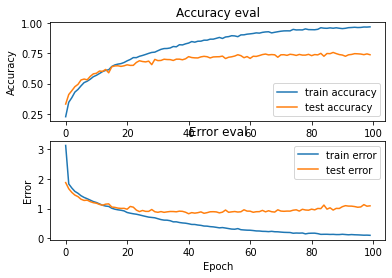

In [17]:
fig, axs = plt.subplots(2)

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# create error sublpot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()

In [18]:
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

63/63 - 2s - loss: 0.9936 - accuracy: 0.7663 - 2s/epoch - 36ms/step

Test accuracy: 0.7662662863731384


In [19]:
model_cnn.save("Music_Genre_10_CNN")

In [20]:
model_cnn.save("Music_Genre_10_CNN.h5")

In [25]:
label_mapping = dict(zip(np.arange(10), data['mapping']))
label_mapping

{0: 'pop',
 1: 'metal',
 2: 'disco',
 3: 'blues',
 4: 'reggae',
 5: 'classical',
 6: 'rock',
 7: 'hiphop',
 8: 'country',
 9: 'jazz'}

In [26]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", label_mapping[y_to_predict])

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_cnn.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", label_mapping[int(predicted_index)])


Real Genre: rock
1/1 [==============================] - 0s 20ms/step
Predicted Genre: reggae

Real Genre: country
1/1 [==============================] - 0s 22ms/step
Predicted Genre: country

Real Genre: blues
1/1 [==============================] - 0s 32ms/step
Predicted Genre: jazz

Real Genre: reggae
1/1 [==============================] - 0s 22ms/step
Predicted Genre: reggae

Real Genre: jazz
1/1 [==============================] - 0s 25ms/step
Predicted Genre: jazz

Real Genre: metal
1/1 [==============================] - 0s 19ms/step
Predicted Genre: metal

Real Genre: hiphop
1/1 [==============================] - 0s 27ms/step
Predicted Genre: hiphop

Real Genre: disco
1/1 [==============================] - 0s 22ms/step
Predicted Genre: disco

Real Genre: blues
1/1 [==============================] - 0s 26ms/step
Predicted Genre: blues

Real Genre: disco
1/1 [==============================] - 0s 25ms/step
Predicted Genre: hiphop
